# Processing the final dataset



In [2]:
import ee
import geemap

# Authenticate to Earth Engine
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

data_folder = "projects/amazon-forest-regrowth/assets"

In [3]:
# region of interest is Amazonia
# roi = ee.FeatureCollection(f"{data_folder}/biomes_br").first().geometry()
# For specific biomes, the feature "CD_Bioma" is:
# 0 = Amazonia
# 1 = Caatinga
# 2 = Cerrado
# 3 = Mata Atlantica
# 4 = Pampa
# 5 = Pantanal

In [19]:
age_agbd = ee.Image(f"{data_folder}/age_agbd")
categorical = ee.Image(f"{data_folder}/categorical")
sur_cover = ee.Image(f"{data_folder}/sur_cover").rename("sur_cover")
one_hectare_mask = ee.Image(f"{data_folder}/one_hectare_mask")
land_use = ee.Image(f"{data_folder}/land_use")
land_use_5_years = ee.Image(f"{data_folder}/land_use_5_years")
land_use_10_years = ee.Image(f"{data_folder}/land_use_10_years")
land_use_15_years = ee.Image(f"{data_folder}/land_use_15_years")
mat_gaus_ker = ee.Image(f"{data_folder}/mat_gaus_ker").rename("mat_gaus_ker") 

zuquim_soil = ee.Image(f"{data_folder}/raw/zuquim_amazon_soil_SB")
cwd = ee.Image(f"{data_folder}/raw/cwd_chave").float().rename("cwd")
yearly_mean_prec = ee.Image(f"{data_folder}/yearly_mean_prec")
yearly_SI = ee.Image(f"{data_folder}/yearly_SI")

# unified_data = age_agbd.addBands([land_use_10_years, cwd]).updateMask(land_use_10_years.select('last_LU')).updateMask(one_hectare_mask)
unified_data = (
    age_agbd.addBands(
        [land_use_5_years, mat_gaus_ker, cwd, categorical, sur_cover, yearly_mean_prec, yearly_SI]
    )
    .updateMask(land_use_5_years.select("last_LU"))
    .updateMask(one_hectare_mask)#.updateMask(mat_gaus_ker)
)

unified_data_fc = unified_data.stratifiedSample(
    numPoints = 10000, classBand = 'ecoreg', region = unified_data.geometry(), geometries = True
)

# Export an ee.FeatureCollection as an Earth Engine asset.
task = ee.batch.Export.table.toDrive(
    collection=unified_data_fc, description="land_use_5_years_mat_gaus_ker"
)

task.start()


In [20]:
mature_biomass = ee.Image(f"{data_folder}/mature_biomass")

map = geemap.Map()
map.addLayer(mature_biomass)
# map.addLayer(mat_for_years, {'min': 0, 'max': 35, 'palette': ['grey', 'green']}, "mat_for_years")
map.addLayer(unified_data, {}, "lulc")
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [5]:
cwd = ee.Image(f"{data_folder}/raw/cwd_chave").float()
yearly_mean_prec = ee.Image(f"{data_folder}/yearly_mean_prec")
yearly_SI = ee.Image(f"{data_folder}/yearly_SI")
categorical = ee.Image(f"{data_folder}/categorical")

mature_biomass = ee.Image(f"{data_folder}/mature_biomass_aggregated")

unified_data = (
    mature_biomass.addBands(
        [cwd, categorical, yearly_mean_prec, yearly_SI]
    ).addBands(mature_biomass.pixelLonLat().float())
    .updateMask(mature_biomass)
)
# landuse = ee.Image('projects/amazon-forest-regrowth/assets/land_use1')

# map = geemap.Map()
# map.addLayer(land_use)
# map.addLayer(mat_for_years, {'min': 0, 'max': 35, 'palette': ['grey', 'green']}, "mat_for_years")
# map.addLayer(unified_data, {}, "lulc")
# map

In [7]:
# # using stratified sample in order to get only the points that have a value for age
# unified_data_fc = unified_data.sample(
#     region = age_agbd.geometry(), geometries = True
# )

unified_data_fc = unified_data.stratifiedSample(
    numPoints = 50000, classBand = 'ecoreg', region = unified_data.geometry(), geometries = True
)


task = ee.batch.Export.table.toAsset(
    collection=unified_data_fc, description="land_use_5_years_fc", assetId=f"{data_folder}/land_use_5_years_fc"
)

task.start()


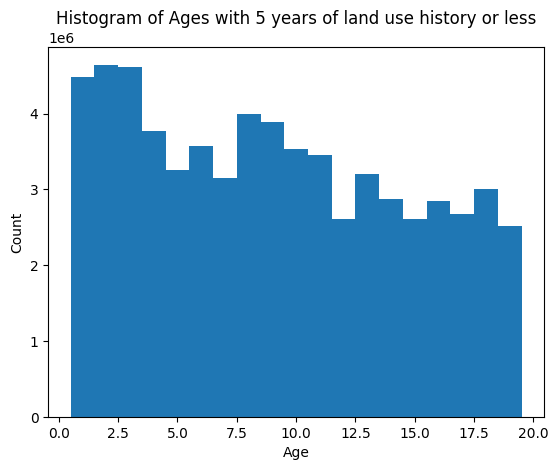

In [9]:
import matplotlib.pyplot as plt

tst = age_agbd.select('age').updateMask(land_use_15_years.select("last_LU")).updateMask(one_hectare_mask)

# 19, 24, 29
histogram_ee = tst.reduceRegion(
    geometry = tst.geometry(), reducer = ee.Reducer.histogram(), maxPixels=1e13
)

hist = histogram_ee.getInfo()

# list(hist.keys())
# Get the bin centers and bin counts
bin_centers = hist['age']['bucketMeans']
bin_counts = hist['age']['histogram']

# Plot the histogram
plt.bar(bin_centers, bin_counts, width=1)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Ages with 5 years of land use history or less')
plt.show()
